# Note for our SOCI 40133 TAs and graders: 
** Due to substantial complexity of the Dynamic Topic Modeling algorithm, we did not complete the computation process of this part, and thus the result is not included in the final paper either. However, we provide the codes in this repository for reference. **

# State ideological proximity based on dynamic topic modeling and semantic network analysis

- Perform dynamic topic modeling. A useful video: https://www.youtube.com/watch?v=3mHy4OSyRf0
- Measure similarities (or divergence) between nations: KL divergence, Jensen Shannon Distance, mutual information coefficient, etc
- Construct network based on the measurement of similarities. 

In [7]:
import os

# Data processing
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

# NLP
import lucem_illud_2020
import spacy
import nltk
import gensim
from wordcloud import WordCloud
nlp = spacy.load('en')

# Machine Learning
import sklearn
import sklearn.manifold
import sklearn.cluster
import sklearn.feature_extraction
import sklearn.decomposition
import sklearn.metrics

%matplotlib notebook

In [4]:
# In the corpus 'URY_40_1985.txt' has been mistakenly named as 'URY_49_1985.txt'. 
# We have corrected it by hand. 

file_path = '../corpus/Converted sessions/'
entry_list = []

list_of_folders = os.listdir(file_path)
for session in list_of_folders:
    if not session.startswith('.') and 'Session' in session: 
        list_of_files = os.listdir(file_path + session)
    else: 
        list_of_files = []
    for country in list_of_files: 
        if not country.startswith('.') and '.txt' in country:
            filename = country.split('.')[0].split('_')
            country_code = filename[0]
            session_code = filename[1]
            year_code = filename[2]
            text = open(file_path + session + '/' + country).read()
            entry_list.append(pd.Series({'filename': country, 
                                         'country_code': country_code, 
                                         'session': session_code, 
                                         'year': year_code, 
                                         'text': text}))

ungdc_df = pd.DataFrame(entry_list)

In [8]:
ungdc_df = ungdc_df.sort_values(by=['session', 'country_code'], axis=0, ascending=(True, True))
ungdc_df = ungdc_df.reset_index(drop=True)

In [49]:
ungdc_df

,filename,country_code,session,year,text
0,ALB_25_1970.txt,ALB,25,1970,33: May I first convey to our President the co...
1,ARG_25_1970.txt,ARG,25,1970,177.\t : It is a fortunate coincidence that pr...
2,AUS_25_1970.txt,AUS,25,1970,100.\t It is a pleasure for me to extend to y...
3,AUT_25_1970.txt,AUT,25,1970,155.\t May I begin by expressing to Ambassado...
4,BEL_25_1970.txt,BEL,25,1970,"176. No doubt each of us, before coming up to ..."
...,...,...,...,...,...
8088,WSM_73_2018.txt,WSM,73,2018,I have had the privilege of addressing the G...
8089,YEM_73_2018.txt,YEM,73,2018,On behalf of the Government and the people of ...
8090,ZAF_73_2018.txt,ZAF,73,2018,I have the honour to address the General Assem...
8091,ZMB_73_2018.txt,ZMB,73,2018,Let me join other world leaders in con...


## Dynamic Topic Modeling

a useful ref: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb

In [47]:
ungdc_countries = {}
ungdc_years = {}

In [52]:
for doc in ungdc_df['filename']: 
    country, session, year = doc.split('.')[0].split('_')
    if country not in ungdc_countries: 
        ungdc_countries[country] = []
    ungdc_countries[country].append(ungdc_df[ungdc_df['filename'] == doc]['text'].values[0])
    if year not in ungdc_years: 
        ungdc_years[year] = []
    ungdc_years[year].append(ungdc_df[ungdc_df['filename'] == doc]['text'].values[0])

In [58]:
ungdc_countries.keys()

dict_keys(['ALB', 'ARG', 'AUS', 'AUT', 'BEL', 'BLR', 'BOL', 'BRA', 'CAN', 'CMR', 'COG', 'COL', 'CRI', 'CUB', 'DOM', 'DZA', 'ECU', 'FRA', 'GBR', 'GHA', 'GIN', 'GMB', 'GTM', 'HND', 'HTI', 'IDN', 'IND', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JPN', 'KEN', 'KHM', 'KWT', 'LBN', 'LBR', 'LBY', 'LKA', 'MAR', 'MDG', 'MEX', 'MMR', 'NLD', 'NOR', 'NZL', 'PAK', 'PER', 'PHL', 'PRY', 'RWA', 'SDN', 'SGP', 'SLE', 'SLV', 'SOM', 'SYR', 'TGO', 'THA', 'TTO', 'TUN', 'TUR', 'UKR', 'URY', 'USA', 'VEN', 'YUG', 'ZAF', 'ZMB', 'AFG', 'BDI', 'BEN', 'BFA', 'BGR', 'CAF', 'CHL', 'CHN', 'CIV', 'COD', 'CSK', 'CYP', 'EGY', 'ESP', 'ETH', 'FIN', 'FJI', 'GAB', 'GRC', 'GUY', 'HUN', 'IRL', 'JAM', 'JOR', 'LAO', 'LUX', 'MLI', 'MLT', 'MNG', 'MRT', 'MUS', 'MYS', 'NER', 'NGA', 'NIC', 'NPL', 'PAN', 'POL', 'QAT', 'ROU', 'RUS', 'SAU', 'SEN', 'SWE', 'TCD', 'TZA', 'UGA', 'YDYE', 'YEM', 'ARE', 'BHR', 'BRB', 'BTN', 'DNK', 'MWI', 'OMN', 'PRT', 'SWZ', 'BHS', 'DDR', 'DEU', 'LSO', 'BGD', 'BWA', 'GNQ', 'GRD', 'MOZ', 'COM', 'CPV', 'GNB', 'MDV', '

In [59]:
ungdc_years.keys()

dict_keys(['1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'])

In [61]:
# Choose time slices: while here we perform topic modeling for each single year, 
# we can also experiment other time slices

# Rearrange the corpora by year
import collections

years = []
year_lens = []

for year_info in collections.OrderedDict(sorted(ungdc_years.items())):
    years.append(year_info)
    year_lens.append(len((ungdc_years[year_info])))

In [62]:
years[0], years[-1]

('1970', '2018')

<IPython.core.display.Javascript object>


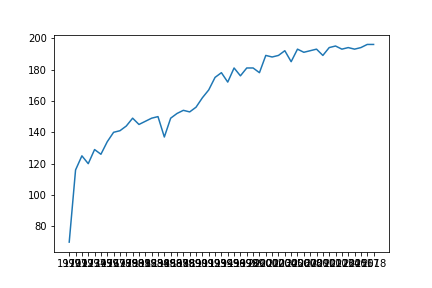

In [63]:
plt.plot(years, year_lens)

In [65]:
# tokenize and normalize the texts, and append to a list

import sklearn.feature_extraction
from nltk.stem.porter import PorterStemmer

def token_norm_stem(text, stemmer):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    stemmed = [stemmer.stem(token) for token in normalized]
    return stemmed

ungdc_all_text = []
stemmer = PorterStemmer()
for year_info in years: 
    for doc in ungdc_years[year_info]: 
        ungdc_all_text.append(token_norm_stem(doc, stemmer))

In [70]:
# the dictionary
lda_dictionary = gensim.corpora.Dictionary(ungdc_all_text)
# the corpus
lda_bow = [lda_dictionary.doc2bow(text) for text in ungdc_all_text]

In [ ]:
gensim.corpora.MmCorpus.serialize('ungdc_lda.mm', corpus)
lda_bow = gensim.corpora.MmCorpus('ungdc_lda.mm')

In [80]:
# lda_dictionary stores the index of each word in the whole corpus
lda_dictionary[5]

'abil'

In [90]:
# lda_bow stores the bag-of-words of each documents in the whole corpus
lda_bow[0][0]

(0, 1)

In [ ]:
ungdc_ldaseq = gensim.models.ldaseqmodel.LdaSeqModel(corpus=lda_bow, id2word=lda_dictionary, time_slice=year_lens, num_topics=30)

/Users/lucient/anaconda3/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [ ]:
# Save the trained LDA model to a file
ungdc_ldaseq.save('ungdc_ldaseq')
# To load the model from the file
# ungdc_ldaseq = gensim.models.ldaseqmodel.load('ungdc_ldaseq')

In [ ]:
# Another implementation of the DTM model in C++ (faster than Python)
# see ref: https://stackoverflow.com/questions/50413059/dynamic-topic-modeling-with-gensim-which-code
# see ref: https://radimrehurek.com/gensim/models/wrappers/dtmmodel.html

# from gensim.models.wrappers.dtmmodel import DtmModel
# import pyLDAvis

# # dtm_path = "/Users/bhargavvader/Downloads/dtm_release/dtm/main"
# # dtm_model = DtmModel(dtm_path, corpus, time_slice, num_topics=5, id2word=dictionary, initialize_lda=True)
# # dtm_model.save('dtm_news')

# # if we've saved before simply load the model
# dtm_model = DtmModel.load('dtm_news')

### topics for each year

In [ ]:
# topics for each year
year = 2018
year_index = years.find(year)
ungdc_ldaseq.print_topics(time=year_index, top_terms=20)

### nation-topic matrix for each year 

In [ ]:
# nation-topic matrix for each year 
year = 2018
year_index = years.find(str(year))
start = sum(year_lens[ : year_index]) + 1
end = start + year_lens[year_index]
nation_topic_matrix = []
for doc_index in range(start, end): 
    nation_topic_matrix.append(ungdc_ldaseq.doc_topics(doc_index_p))
nation_topic_matrix = np.array(nation_topic_matrix)

# visualize nation-topic probability matrix
fig = plt.figure()
country_list = ungdc_df[ungdc_df['year'] == str(year)]['country_code'].values
div = pandas.DataFrame(nation_topic_matrix, columns=['Topic_{topic}' for topic in range(30)], index=country_list) # 30 is the number of topics
ax = sns.heatmap(div)
plt.show()

### topic dynamics over years
Investigate the change of relevant words of each topic over years. 

In [ ]:
# topic dynamics over years
ungdc_ldaseq.print_topic_times(topic=0)

### Visualize significant words for each topic over years 
using pyLDAvis

In [ ]:
# visualize using pyLDAvis
import pyLDAvis

# a useful ref: https://cloud.tencent.com/developer/article/1435976

year = '2018' # we can visualize the result for one year at a time. 

doc_topic, topic_term, doc_lengths, term_frequency, vocab = ungdc_ldaseq.dtm_vis(time=str(year), corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, 
                               doc_topic_dists=doc_topic, 
                               doc_lengths=doc_lengths, 
                               vocab=vocab, 
                               term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

In [ ]:
# save the visualization results to html file
with open('ungdc_ldaseq_vis.html', 'w') as fhand: 
    pyLDAvis.save_html(ungdc_ldaseq_vis, fhand)

### extension: Topic Coherence
https://nbviewer.jupyter.org/github/dsquareindia/gensim/blob/280375fe14adea67ce6384ba7eabf362b05e6029/docs/notebooks/topic_coherence_tutorial.ipynb#topic=0&lambda=1&term=

## Measure similarities (or divergence) between nations over years
Here we use Normalized Mutual Information Score implemented by sklearn.metrics.normalized_mutual_info_score

In [ ]:
from gensim.matutils import jensen_shannon
from sklearn.metrics import normalized_mutual_info_score

def pairwise_jsd(year): 
    year_index = years.find(str(year))
    start = sum(year_lens[ : year_index]) + 1
    end = start + year_lens[year_index]
    score_matrix = []
    for doc_index_p in range(start, end): 
        p_vec = ungdc_ldaseq.doc_topics(doc_index_p)
        score_column = []
        for doc_index_q in range(start, end): 
            q_vec = ungdc_ldaseq.doc_topics(doc_index_q)
            score_column.append(1 - jensen_shannon(p_vec, q_vec)) # 1 - jsd measures the extent of similarity
        score_matrix.append(jsd_column)
    return np.array(score_matrix)

def pairwise_nmi(year): 
    year_index = years.find(str(year))
    start = sum(year_lens[ : year_index]) + 1
    end = start + year_lens[year_index]
    score_matrix = []
    for doc_index_p in range(start, end): 
        p_vec = ungdc_ldaseq.doc_topics(doc_index_p)
        score_column = []
        for doc_index_q in range(start, end): 
            q_vec = ungdc_ldaseq.doc_topics(doc_index_q)
            score_column.append(normalized_mutual_info_score(p_vec, q_vec))
        score_matrix.append(jsd_column)
    return np.array(score_matrix)

In [ ]:
# visualize country-wise similarities

year = 2018 # specify the year here

country_list = ungdc_df[ungdc_df['year'] == str(year)]['country_code'].values

fig = plt.figure()
div = pandas.DataFrame(pairwise_nmi(year), columns=country_list, index=country_list)
ax = sns.heatmap(div)
plt.show()

## Construct network based on the measurement of similarities.

In [ ]:
year = 2018

# Create a graph based on pairwise KL divergence
ungdc_dtm_network = nx.Graph()
# Add nodes
ungdc_dtm_network.add_nodes_from(country_list)
# score matrix
score_matrix = pairwise_nmi(year)

# Add edges and weights
for p, country_p in enumerate(country_list):
    for q, country_q in enumerate(country_list):
        if (country_p != country_q) & (ungdc_dtm_network.has_edge(country_p, country_q) == False):
            ungdc_dtm_network.add_edge(country_p, country_q, weight=score_matrix[p, q])

In [ ]:
print(nx.info(ungdc_dtm_network))